# Single Market Maker - via Pontryagin

This notebook corresponds to section 4 (**Agent based models**) of "Market Based Mechanisms for Incentivising Exchange Liquidity Provision" available [here](https://vega.xyz/papers/liquidity.pdf). It models a single market maker and solves the resulting game by an iterative scheme based on the Pontryagin optimality principle.

In [1]:
import math, sys 
import numpy as np

from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
T = 2;
gamma = 0.1
sigma = 0.5
lambd = 0.1
r = 0.0
rRisk = 0.1

delta = 1e-3

# This is the key; how does instantenaous trading volume react 
# to market making stake
# and to fees
def fee_volume_response(f):
    f = np.minimum(f, np.ones(np.size(f)))
    return 1.0/(f+0.001) - f

def stake_volume_response(S):
    return 1.0 / (1+np.exp(-0.05*S+2)) - 1.0 / (1+np.exp(2))

def trading_volume(f,S):
    N_max = 10000
    return  N_max * fee_volume_response(f) * stake_volume_response(S)
    
def running_gain(t,f,S,a1,a2):
    return np.exp(-r*t) * (f * trading_volume(f,S) - lambd * sigma * S) - np.exp(rRisk*t)*S \
              - delta * a1*a1 - delta * a2*a2

def running_gain_x(t,x,a):
    f = x[0]
    S = x[1]
    return running_gain(t,f,S, a[0], a[1])

def grad_x_of_running_gain(t,x,a):
    delta = 1e-6
    grad = np.zeros(2)

    x_plus = x + np.array([delta, 0])
    x_minus = x - np.array([delta, 0])
    rg_plus = running_gain_x(t,x_plus,a)
    rg_minus = running_gain_x(t,x_minus,a)

    grad[0] = (rg_plus - rg_minus)/(2*delta)
    
    x_plus = x + np.array([0, delta])
    x_minus = x - np.array([0, delta])
    rg_plus = running_gain_x(t,x_plus,a)
    rg_minus = running_gain_x(t,x_minus,a)
    grad[1] = (rg_plus - rg_minus)/(2*delta)
                            
    return grad

0.9812588431563035
0.07907907907907907
0.9812588431563035


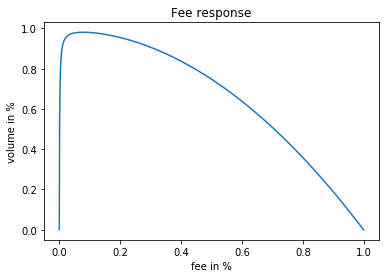

In [3]:
x_span = np.linspace(0,1, 1000) 
y = x_span*fee_volume_response(x_span)
print(max(y))
max_idx=np.argmax(y)
print(x_span[max_idx])
print(y[max_idx])
plt.xlabel('fee in %')
plt.ylabel('volume in %')
plt.title('Fee response')
plt.plot(x_span,y)

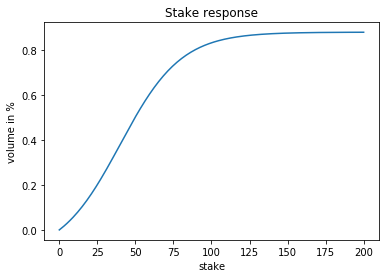

In [4]:
x_span = np.linspace(0,200, 200) 
y = stake_volume_response(x_span)
plt.xlabel('stake')
plt.ylabel('volume in %')
plt.title('Stake response')
plt.plot(x_span,y)

In [5]:
# Alternative initialization 

L_S = 300;
L_f = 1;

N_T = 200; delta_t = T / (N_T-1);
N_S = 90; 
N_f = 90; 

t_span = np.linspace(0, T, N_T)
f_span = np.linspace(0, L_f, N_f)
S_span = np.linspace(0, L_S, N_S)

def grid_idx_from(S,S_span):
    min_S = S_span[0]
    N_S = np.size(S_span)
    max_S = S_span[N_S-1]
    delta_S = (max_S-min_S)/(N_S-1)
    return max(min(int(round(S/delta_S)), N_S-1),0)

In [6]:
F_vals = np.zeros([np.size(f_span), np.size(S_span)])
grad_F_vals = np.zeros([np.size(f_span), np.size(S_span), 2])
for f_idx in range(0, np.size(f_span)):
    for S_idx in range(0, np.size(S_span)):
        f = f_span[f_idx]
        S = S_span[S_idx]
        F_vals[f_idx,S_idx] = running_gain(T, f, S, 0, 0)
        grad_F_vals[f_idx,S_idx,:] = grad_x_of_running_gain(T, np.array([f, S]), np.array([0,0]))
        
max_idx = np.unravel_index(np.argmax(F_vals, axis=None),F_vals.shape)
print(f_span[max_idx[0]])
print(S_span[max_idx[1]])

0.07865168539325842
158.42696629213484


Text(0.5, 0, 'F')

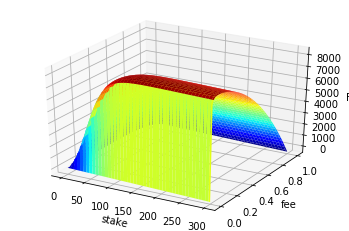

In [7]:
plotGridX, plotGridY = np.meshgrid(S_span, f_span)
fig = plt.figure()
ax1 = fig.gca(projection='3d')
surf = ax1.plot_surface(plotGridX, plotGridY, F_vals[:,:], cmap=cm.jet, antialiased=True)
ax1.set_xlabel('stake')
ax1.set_ylabel('fee')
ax1.set_zlabel('F')

In [8]:
# Fix learning rate rho
rho = 0.1
max_iter = 20
max_error = 1e-3


b_vec = np.array([0.01, 10])

actions = np.zeros([2,N_T+1])
actions_old = np.zeros([2,N_T+1])

# fees are the 0th component, stake is the 1st component
x_vals = np.zeros([2,N_T+1])
x_vals[:,0] = np.array([0.75, 5])
y_vals = np.zeros([2,N_T+1])

diff = 0; failed_to_converge=True
for iter_idx in range(0,max_iter):
    # Run x forwards
    for i in range(0,N_T):
        x_vals[:,i+1] = x_vals[:,i] + b_vec * actions[:,i] * delta_t
    
    # Run y backwards
    y_vals[:,N_T] = np.zeros(2)
    for i in reversed(range(0,N_T)):
        grad_x_F = grad_x_of_running_gain(t_span[i], x_vals[:,i],actions[:,i])
        #print(grad_x_F)
        y_vals[:,i] = y_vals[:,i+1] + grad_x_F * delta_t 
    
    
    for i in range(0,N_T):
        # Do one gradient ascent step (we are maximizing) and note that (\nabla_a H)(t,x,y,a) = (- \gamma y^1, y^2) - 2\delta ( a^1, a^2)
        # actions[:,i] = actions[:,i] + (rho/(iter_idx+1))*(delta_t)*(b_vec*y_vals[:,i] - 2*delta*actions[:,i])
        actions[:,i] = actions[:,i] + rho*(b_vec*y_vals[:,i] - 2*delta*actions[:,i])
        # actions[:,i] = 1.0/(2*delta) * b_vec * y_vals[:,i]
        
        # Another option is to actually try to maximize the Hamiltonian here.
        # H = lambda  a: -(np.dot(b_vec*y_vals[:,i],a) + running_gain_x(t_span[i], x_vals[:,i], a))
        # res = minimize(H, [0,0], method='BFGS')
        # if (res.success == False):
        #    print('Iteration %d, time %f, local minimizaiton failed.' % (iter_idx, t_span[i]))
        #    break
        # actions[:,i] = res.x
        
    diff = np.max(np.abs(actions - actions_old)) 
    if (diff < max_error):
        print('Converged; iteration %d, diff is %f' % (iter_idx, diff))
        failed_to_converge = False
        break 
    actions_old = np.copy(actions)

if failed_to_converge:
    print('Failed after %d iteration, diff is %f' % (max_iter, diff))

Failed after 20 iteration, diff is 3.537616


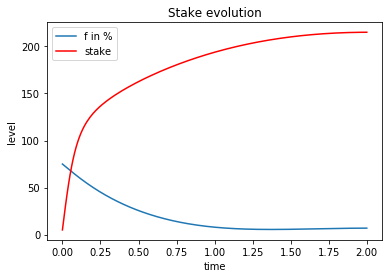

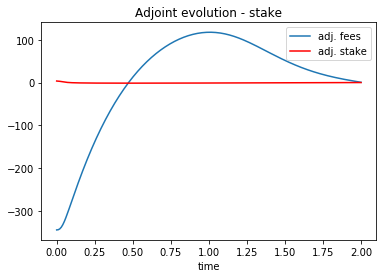

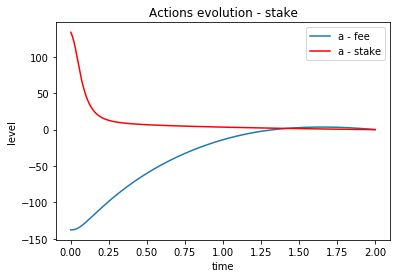

In [9]:
plt.plot(t_span, 100*x_vals[0,0:N_T].T,label='f in %')
plt.title('Fees evolution')
plt.xlabel('time')
plt.plot(t_span, x_vals[1,0:N_T].T,color='red',label='stake')
plt.title('Stake evolution')
plt.xlabel('time')
plt.ylabel('level')
plt.legend()

fig = plt.figure()
plt.plot(t_span, 0.1*y_vals[0,0:N_T].T, label='adj. fees')
plt.title('0.1 x Adjoint evolution - fees')
plt.xlabel('time')
plt.plot(t_span, y_vals[1,0:N_T].T, color = 'red', label='adj. stake')
plt.title('Adjoint evolution - stake')
plt.xlabel('time')
plt.legend()

fig = plt.figure()
plt.plot(t_span, actions[0,0:N_T].T,label='a - fee')
plt.title('Actions evolution - fees')
plt.xlabel('time')
plt.ylabel('actions fees')
plt.plot(t_span, actions[1,0:N_T].T, color='red',label='a - stake')
plt.title('Actions evolution - stake')
plt.xlabel('time')
plt.ylabel('level')
plt.legend()

In [10]:
x_vals[1,N_T-1]

215.07124795571218

In [11]:
f = lambda x: x[0]*x[0] + x[1]*x[1]
res = minimize(f, [0.25,-0.25])
print(res)

      fun: 1.1102230246251588e-16
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 6.66133815e-16, -6.66133815e-16])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-7.45058026e-09, -7.45058093e-09])


-10.0
30.0
-1533.69396011475
      fun: -615234.5486997258
 hess_inv: array([[ 264.32441712, -272.80770906],
       [-272.80770906,  283.61278265]])
      jac: array([-0.0078125, -0.0078125])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 4
     njev: 101
   status: 2
  success: False
        x: array([-17252.48120218,  17819.13423117])


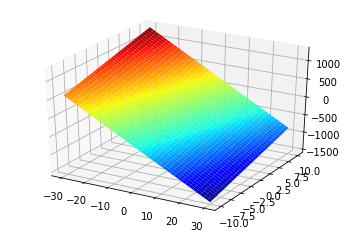

In [12]:
i = 0
H = lambda  a: -(np.dot(b_vec*y_vals[:,i],a) + running_gain_x(t_span[i], x_vals[:,i], a))

a_f_span = np.linspace(-10, 10, 160)
a_S_span = np.linspace(-30, 30, 160)
H_vals = np.zeros([np.size(a_f_span), np.size(a_S_span)])

for a_f_idx in range(0, np.size(a_f_span)):
    for a_S_idx in range(0, np.size(a_S_span)):
        a_f = a_f_span[a_f_idx]
        a_S = a_S_span[a_S_idx]
        H_vals[a_f_idx,a_S_idx] = H(np.array([a_f, a_S]))

max_idx = np.unravel_index(np.argmin(H_vals, axis=None),H_vals.shape)
print(a_f_span[max_idx[0]])
print(a_S_span[max_idx[1]])
print(H_vals[max_idx])

plotGridX, plotGridY = np.meshgrid(a_S_span, a_f_span)
fig = plt.figure()
ax1 = fig.gca(projection='3d')
surf = ax1.plot_surface(plotGridX, plotGridY, H_vals, cmap=cm.jet, antialiased=True)

res = minimize(H, [100,-100],method='BFGS')
actions[:,i] = res.x
print(res)

In [13]:
H([-7.84168702e-06, -7.84168702e-06])

array([-120.55962041])

In [14]:
running_gain_x(t_span[i], x_vals[:,i], [5,5])

array([120.5096293])

In [15]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [16]:
res = minimize(H, [100,-100],method='Nelder-Mead')
actions[:,i] = res.x
print(res)

 final_simplex: (array([[-17251.68395723,  17818.34428676],
       [-17251.6839597 ,  17818.34423046],
       [-17251.68394514,  17818.34426788]]), array([-615234.54995943, -615234.54995943, -615234.54995943]))
           fun: -615234.5499594298
       message: 'Optimization terminated successfully.'
          nfev: 184
           nit: 93
        status: 0
       success: True
             x: array([-17251.68395723,  17818.34428676])


In [17]:
res = minimize(H, [100,-100],method='Powell')
actions[:,i] = res.x
print(res)

   direc: array([[1., 0.],
       [0., 1.]])
     fun: array(-615234.54995943)
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 2
  status: 0
 success: True
       x: array([-17251.6840073 ,  17818.34418085])


In [18]:
# Fix learning rate rho
rho = 1000
max_iter = 1000
max_error = 1e-2

b_vec = np.array([-gamma, 1])

actions = np.zeros([2,N_T+1])
actions_old = np.zeros([2,N_T+1])

# fees are the 0th component, stake is the 1st component
x_vals = np.zeros([2,N_T+1])
x_vals[:,0] = np.array([0.1, 30])
y_vals = np.zeros([2,N_T+1])

diff = 0; failed_to_converge=True
for iter_idx in range(0,max_iter):
    # Run x forwards
    for i in range(0,N_T):
        x_vals[:,i+1] = x_vals[:,i] + b_vec * actions[:,i] * delta_t
    
    # Run y backwards
    y_vals[:,N_T] = np.zeros(2)
    for i in reversed(range(0,N_T)):
        grad_x_F = grad_x_of_running_gain(t_span[i], x_vals[:,i],actions[:,i])
        #print(grad_x_F)
        y_vals[:,i] = y_vals[:,i+1] + grad_x_F * delta_t 
    
    # Do one gradient ascent step (we are maximizing) and note that (\nabla_a H)(t,x,y,a) = (- \gamma y^1, y^2) - 2\delta ( a^1, a^2)
    for i in range(0,N_T):
        actions[:,i] = actions[:,i] + (rho/(iter_idx+1))*(delta_t)*(b_vec*y_vals[:,i] - 2*delta*actions[:,i])

        
    diff = np.max(np.abs(actions - actions_old))
    if (diff < max_error):
        print('Iteration %d, diff is %f' % (iter_idx, diff))
        failed_to_converge = False
        break 
    actions_old = np.copy(actions)

if failed_to_converge:
    print('Failed after %d iteration, diff is %f' % (max_iter, diff))

Failed after 1000 iteration, diff is 11.282312


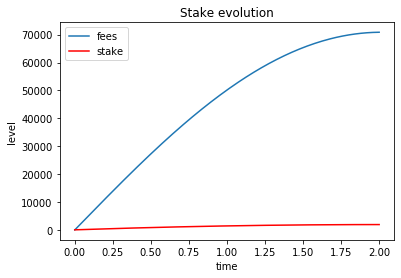

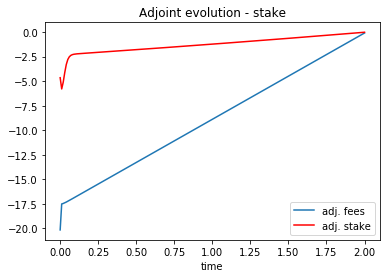

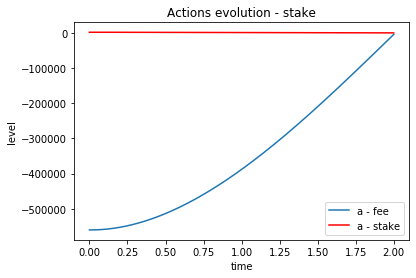

In [19]:
plt.plot(t_span, x_vals[0,0:N_T],label='fees')
plt.title('Fees evolution')
plt.xlabel('time')
plt.plot(t_span, x_vals[1,0:N_T],color='red',label='stake')
plt.title('Stake evolution')
plt.xlabel('time')
plt.ylabel('level')
plt.legend()

fig = plt.figure()
plt.plot(t_span, y_vals[0,0:N_T], label='adj. fees')
plt.title('Adjoint evolution - fees')
plt.xlabel('time')
plt.plot(t_span, y_vals[1,0:N_T], color = 'red', label='adj. stake')
plt.title('Adjoint evolution - stake')
plt.xlabel('time')
plt.legend()

fig = plt.figure()
plt.plot(t_span, actions[0,0:N_T],label='a - fee')
plt.title('Actions evolution - fees')
plt.xlabel('time')
plt.ylabel('actions fees')
plt.plot(t_span, actions[1,0:N_T], color='red',label='a - stake')
plt.title('Actions evolution - stake')
plt.xlabel('time')
plt.ylabel('level')
plt.legend()

In [20]:
y[100]

0.8344934761313109